# Overview

This notebook imports raw ws3 input data, reformats and monkey-patches the data, and exports Woodstock formatted input data files (which we will use in other DSS notebooks for this case as the input data files). 

# Set up environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import ws3.forest, ws3.core
import csv
import numpy as np
import time
from functools import partial, wraps
import distance
import operator
import os

Define some key model parameters (will get used but defined here up top for convenience).

In [3]:
period_length = 10
max_age =  1000

In [81]:
# Input paths
# TSA 03, 12, 14, 20, 24
vdyp_curves_smooth_tsa03_path = './data/vdyp_curves_smooth-tsa03.feather'
vdyp_curves_smooth_tsa12_path = './data/vdyp_curves_smooth-tsa12.feather'
vdyp_curves_smooth_tsa14_path = './data/vdyp_curves_smooth-tsa14.feather'
vdyp_curves_smooth_tsa20_path = './data/vdyp_curves_smooth-tsa20.feather'
vdyp_curves_smooth_tsa24_path = './data/vdyp_curves_smooth-tsa24.feather'

stands_shape_file_path = './data/equitysilver_largedata/equitysilver.shp'


# Output paths
stands_csv_path = './data/large_data/equitysilver_stands.csv'

stands__csv_path = './data/large_data/equitysilver_stands_.csv'

stands_mdf_csv_path = './data/large_data/equitysilver_stands_mdf.csv'

yld_vdyp_03_csv_path = './data/large_data/yld_vdyp_03.csv'
yld_vdyp_12_csv_path = './data/large_data/yld_vdyp_12.csv'
yld_vdyp_14_csv_path = './data/large_data/yld_vdyp_14.csv'
yld_vdyp_20_csv_path = './data/large_data/yld_vdyp_20.csv'
yld_vdyp_24_csv_path = './data/large_data/yld_vdyp_24.csv'
yld_vdyp_csv_path = './data/large_data/yld_vdyp_equitysilver.csv'


yldmerged_csv_path = './data/large_data/equitysilver_yldmerged.csv'

woodstock_model_files_lan_path = './data/woodstock_model_files_equitysilver/equitysilver.lan'
woodstock_model_files_are_path = './data/woodstock_model_files_equitysilver/equitysilver.are'
woodstock_model_files_yld_path = './data/woodstock_model_files_equitysilver/equitysilver.yld'
woodstock_model_files_act_path = './data/woodstock_model_files_equitysilver/equitysilver.act'
woodstock_model_files_trn_path = './data/woodstock_model_files_equitysilver/equitysilver.trn'

In [5]:
yld_vdyp_03 = pd.read_feather(vdyp_curves_smooth_tsa03_path)
yld_vdyp_03

,index,age,volume,stratum_code,si_level
0,8,9,1.062753e-13,SBS_SX,L
1,9,10,4.118229e-10,SBS_SX,L
2,10,11,1.858092e-08,SBS_SX,L
3,11,12,2.237515e-07,SBS_SX,L
4,12,13,1.413441e-06,SBS_SX,L
...,...,...,...,...,...
13205,294,295,2.351395e+02,ICH_BL,H
13206,295,296,2.338344e+02,ICH_BL,H
13207,296,297,2.325311e+02,ICH_BL,H
13208,297,298,2.312298e+02,ICH_BL,H


In [6]:
yld_vdyp_12 = pd.read_feather(vdyp_curves_smooth_tsa12_path)
yld_vdyp_12

,index,age,volume,stratum_code,si_level
0,0,1,3.483548e-98,SBS_SX,L
1,1,2,1.461516e-17,SBS_SX,L
2,2,3,1.351616e-12,SBS_SX,L
3,3,4,8.795601e-10,SBS_SX,L
4,4,5,7.522028e-08,SBS_SX,L
...,...,...,...,...,...
13241,294,295,2.323155e+02,ICH_BL,H
13242,295,296,2.310142e+02,ICH_BL,H
13243,296,297,2.297147e+02,ICH_BL,H
13244,297,298,2.284173e+02,ICH_BL,H


In [7]:
yld_vdyp_14 = pd.read_feather(vdyp_curves_smooth_tsa14_path)
yld_vdyp_14
yld_vdyp_14.to_csv('./data/yld_vdyp_14.csv', index=False)

In [8]:
yld_vdyp_20 = pd.read_feather(vdyp_curves_smooth_tsa20_path)
yld_vdyp_20

,index,age,volume,stratum_code,si_level
0,8,9,1.217042e-12,SBS_SX,L
1,9,10,2.638289e-09,SBS_SX,L
2,10,11,9.107819e-08,SBS_SX,L
3,11,12,9.208523e-07,SBS_SX,L
4,12,13,5.110722e-06,SBS_SX,L
...,...,...,...,...,...
13207,294,295,2.391124e+02,ICH_BL,H
13208,295,296,2.378125e+02,ICH_BL,H
13209,296,297,2.365141e+02,ICH_BL,H
13210,297,298,2.352175e+02,ICH_BL,H


In [9]:
yld_vdyp_24 = pd.read_feather(vdyp_curves_smooth_tsa24_path)
yld_vdyp_24

,index,age,volume,stratum_code,si_level
0,13,14,3.697156e-10,SBS_SX,L
1,14,15,2.153949e-07,SBS_SX,L
2,15,16,4.056603e-06,SBS_SX,L
3,16,17,2.760469e-05,SBS_SX,L
4,17,18,1.142533e-04,SBS_SX,L
...,...,...,...,...,...
7029,294,295,2.974311e+02,ESSF_PLI,H
7030,295,296,2.965865e+02,ESSF_PLI,H
7031,296,297,2.957375e+02,ESSF_PLI,H
7032,297,298,2.948842e+02,ESSF_PLI,H


# Import and reformat inventory and yield input data

Read forest inventory data into memory (vector polygon GIS data layer with attribute table, in ESRI Shapefile format). This dataset represents timber supply area (TSA) 04 in British Columbia. We monkey-patch the inventory data here to make it line up nicely with what we need downstream as input for the ws3 model (i.e., changes we make here to the in-memory dataset are not saved to the original dataset on disk). Most of what we are doing here is setting up the _theme_ columns in the attribute table, which should help newer ws3 users make the connection between input data and the landscape themes in ws3 model further down.

In [10]:
Start = time.time()
stands = gpd.read_file(stands_shape_file_path)
print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")
stands

It took 2.6 minutes to run this script.


,TSA_NUMBER,FEATURE_AR,BCLCS_LEVE,BEC_ZONE_C,SITE_INDEX,SPECIES_CD,SPECIES_PC,SPECIES__1,SPECIES__2,Shape_Leng,Shape_Area,contclass,rollup,netdown,THLB_Area,Block_ID,Age_2024,Field,geometry
0,03,0.0,TB,SBS,28.1,ACT,70.0,AT,20.0,542.471610,7605.345504,C,THLB,THLB,0.760535,11,169,0,"POLYGON ((929613.886 1075271.492, 929619.001 1..."
1,03,0.0,TB,SBS,28.1,ACT,70.0,AT,20.0,226.766164,2403.878713,C,THLB,THLB,0.240388,12,169,0,"POLYGON ((929875.826 1075374.619, 929875.039 1..."
2,03,0.0,TB,SBS,33.1,ACT,80.0,SX,20.0,356.611651,4742.108652,C,THLB,THLB,0.474211,45,149,0,"POLYGON ((931082.851 1079548.388, 931068.969 1..."
3,03,0.0,TB,SBS,33.1,ACT,80.0,SX,20.0,944.540051,11667.892744,C,THLB,THLB,1.166789,46,149,0,"POLYGON ((930673.339 1079366.691, 930614.013 1..."
4,03,0.0,TB,SBS,34.3,ACT,95.0,SX,5.0,293.766619,4343.589922,C,THLB,THLB,0.434359,47,149,0,"POLYGON ((929919.218 1079375.897, 929796.921 1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382964,03,0.0,TB,SBS,15.8,AT,100.0,None,0.0,265.738019,1565.332342,C,THLB,THLB,0.156533,549716,79,0,"POLYGON ((924795.125 1081330.306, 924800.682 1..."
382965,03,0.0,TB,SBS,20.0,AT,80.0,ACT,20.0,726.691560,5501.651217,C,THLB,THLB,0.550165,549717,98,0,"POLYGON ((935524.713 1081215.322, 935505.054 1..."
382966,03,0.0,TC,SBS,16.0,BL,40.0,SX,30.0,292.972149,1826.148462,C,THLB,THLB,0.182615,549718,33,0,"POLYGON ((947102.482 1081233.615, 947082.870 1..."
382967,03,0.0,TC,SBS,14.1,BL,60.0,SX,40.0,1032.277379,10096.452395,C,THLB,THLB,1.009645,549719,169,0,"POLYGON ((944784.385 1081319.436, 944765.166 1..."


Import CANFI tree species lookup table (associates tree species names with integer numerical values, which we use as theme data values in the ws3 model), and insert species code values into the yield curve dataframe.

In [11]:
canfi_map = {'AC':1211, 
             'AT':1201,
             'ACT':1201,
             'BL':304,
             'B' :304, #based on 00_data_prep_Resultant.ipynp
             'BA': 304, # added manually
             'EP':1303, 
             'FDI':500, 
             'H' :400,
             'HW':402,
             'HM':403,
             'PL':204, 
             'PLI':204,
             'PA':204,
             'SB':101, 
             'SE':104, 
             'SW':105, 
             'SX':100,
             'S':100,
             'SXS':100, # added manually
             'SXW':100, # added manually
             'CW': 701, # Eastern white-cedar           
            'AT+SX':1201,
            'SX+AT':100,
            'SX+ACT' :100}

In [12]:
Aspen = ['AC', 'ACT', 'AT', 'EP', 'VB', 'MB', 'AT+SX']
Bal = ['B', 'BA', 'BG', 'BL']
Cedar = ['CW', 'YC']
Alder = ['D', 'DR']
DougFir = ['F', 'FD', 'FDC', 'FDI']
Hem = ['H', 'HM', 'HW']
Pine = ['PA', 'PL', 'PLC', 'PW', 'PLI', 'PY']
Spruce = ['S', 'SS', 'SW', 'SX', 'SE', 'SXW', 'SB', 'SXS', 'SX+AT']

Burn CANFI species codes into yield data tables.

In [13]:
def canfi_species(stratum_code):
    s = stratum_code.split('_')[-1].split('+')[0]
    result = canfi_map[s]
    return result

In [14]:
def stratify_stand(r, lexmatch=False, lexmatch_fieldname_suffix='_lexmatch'):
    result = ''
    if lexmatch:
        result += 3 * r['BEC_ZONE_CODE%s' % lexmatch_fieldname_suffix]
        result += '_'
        result += 2 * r['SPECIES_CD_1%s' % lexmatch_fieldname_suffix]
        if r.BCLCS_LEVE == 'TM' and r.SPECIES__1 != None:
            result += '+' + r['SPECIES_CD_2%s' % lexmatch_fieldname_suffix]
    else:
        result += r.BEC_ZONE_C
        result += '_'
        result += r.SPECIES_CD
        if r.BCLCS_LEVE == 'TM' and r.SPECIES__1 != None:
            result += '+' + r.SPECIES__1
    return result

There are no species data for 3,725 stands, so we used the dominant species for each BEC zone in each TSA to fill in the missing information.

| TSA_NUMBER | BEC_ZONE_C    | SPECIES_CD   |
|------------|---------------|--------------|
| 3          | BAFA          | BL           |
| 3          | CWH           | BL           |
| 3          | ESSF          | BL           |
| 3          | ICH           | SX           |
| 3          | SBS           | AT           |
| 12         | BAFA          | BL           |
| 12         | CWH           | HW           |
| 12         | ESSF          | B            |
| 12         | ICH           | AT           |
| 12         | MH            | B            |
| 14         | ESSF          | BL           |
| 14         | SBS           | SX           |
| 20         | BAFA          | BL           |
| 20         | CWH           | HM           |
| 20         | ESSF          | BL           |
| 20         | SBS           | SX           |
| 24         | ESSF          | SE           |
| 24         | SBS           | AT           |







In [15]:
# Display rows where 'SPECIES_CD' is None
print(stands[stands['SPECIES_CD'].isna()])

       TSA_NUMBER  FEATURE_AR BCLCS_LEVE BEC_ZONE_C  SITE_INDEX SPECIES_CD  \
429            20         0.0         SL        SBS         0.0       None   
478            20         0.0         SL        SBS         0.0       None   
1059           20         0.0         SL        SBS         0.0       None   
1060           20         0.0         SL        SBS         0.0       None   
1115           20         0.0         SL        SBS         0.0       None   
...           ...         ...        ...        ...         ...        ...   
382201         03         0.0         SL        SBS         0.0       None   
382202         03         0.0         SL        SBS         0.0       None   
382765         03         0.0         SL        SBS         0.0       None   
382766         03         0.0         SL        SBS         0.0       None   
382767         03         0.0         SL        SBS         0.0       None   

        SPECIES_PC SPECIES__1  SPECIES__2   Shape_Leng     Shap

In [16]:
species_mapping = {
('03',	'BAFA'): 	'BL',
('03',	'CWH'):	'BL',
('03',	'ESSF'):	'BL',
('03',	'ICH'):	'SX',
('03',	'SBS'):	'AT',
('12',	'BAFA'):	'BL',
('12',	'CWH'):	'HW',
('12',	'ESSF'):	'B',
('12',	'ICH'):	'AT',
('12',	'MH'):	'B',
('14',	'ESSF'):	'BL',
('14',	'SBS'):	'SX',
('20',	'BAFA'):	'BL',
('20',	'CWH'):	'HM',
('20',	'ESSF'):	'BL',
('20',	'SBS'):	'SX',
('24',	'ESSF'):	'SE',
('24',	'SBS'):	'AT'
}

In [17]:
def update_null_species_cd(row):
    if pd.isna(row['SPECIES_CD']):
        key = (row['TSA_NUMBER'], row['BEC_ZONE_C'])
        # print(f"Row: {row}, Key: {key}")  # Debug statement
        return species_mapping.get(key, row['SPECIES_CD'])
    return row['SPECIES_CD']

In [18]:
stands['SPECIES_CD'] = stands.apply(update_null_species_cd, axis=1)

In [19]:
# Display rows where 'SPECIES_CD' is None
print(stands[stands['SPECIES_CD'].isna()])

Empty GeoDataFrame
Columns: [TSA_NUMBER, FEATURE_AR, BCLCS_LEVE, BEC_ZONE_C, SITE_INDEX, SPECIES_CD, SPECIES_PC, SPECIES__1, SPECIES__2, Shape_Leng, Shape_Area, contclass, rollup, netdown, THLB_Area, Block_ID, Age_2024, Field, geometry]
Index: []


In [20]:
stands.to_csv(stands_csv_path, index=False)

In [21]:
stands['BEC_ZONE_CODE_lexmatch'] = stands.BEC_ZONE_C.str.ljust(4, fillchar='x')

stands['SPECIES_CD_1_lexmatch'] = stands['SPECIES_CD'].str.ljust(4, 'x')
stands['SPECIES_CD_1_lexmatch'] = stands['SPECIES_CD'].str[:1] + stands['SPECIES_CD']

stands['SPECIES_CD_2_lexmatch'] = stands['SPECIES__1'].str.ljust(4, 'x')
stands['SPECIES_CD_2_lexmatch'] = stands['SPECIES__1'].str[:1] + stands['SPECIES__1']

stratify_stand = stratify_stand
stratify_stand_lexmatch = partial(stratify_stand, lexmatch=True)

stands['stratum'] = stands.apply(stratify_stand, axis=1)
stands['stratum_lexmatch'] = stands.apply(stratify_stand_lexmatch, axis=1)

Read yield data from a CSV file and recast AU column data type to integer.

In [22]:
# Define a function to process yld_vdyp for each TSA
def process_yld_vdyp_dataframe(path, start_value):
    df = pd.read_feather(path)
    df['canfi_species'] = df.apply(lambda row: canfi_species(row['stratum_code']), axis=1).astype(int)
    df['au_vdyp'] = pd.factorize(df['stratum_code'] + '_' + df['si_level'])[0] + start_value
    return df

paths = {
    'yld_vdyp_03': (vdyp_curves_smooth_tsa03_path, 1),
    'yld_vdyp_12': (vdyp_curves_smooth_tsa12_path, 46),
    'yld_vdyp_14': (vdyp_curves_smooth_tsa14_path, 91),
    'yld_vdyp_20': (vdyp_curves_smooth_tsa20_path, 181),
    'yld_vdyp_24': (vdyp_curves_smooth_tsa24_path, 225),
}

dataframes = {name: process_yld_vdyp_dataframe(path, start_value) for name, (path, start_value) in paths.items()}

yld_vdyp_03 = dataframes['yld_vdyp_03']
yld_vdyp_12 = dataframes['yld_vdyp_12']
yld_vdyp_14 = dataframes['yld_vdyp_14']
yld_vdyp_20 = dataframes['yld_vdyp_20']
yld_vdyp_24 = dataframes['yld_vdyp_24']

# print(yld_vdyp_03.head())
# print(yld_vdyp_12.head())
# print(yld_vdyp_14.head())
# print(yld_vdyp_20.head())
# print(yld_vdyp_24.head())

In [24]:
# Uncommon values in yld_vdyp_?_ not in stands_?_

# uncommon_in_yld_vdyp = yld_vdyp_24_.index.difference(stands_24_.index)
# print("Uncommon values in yld_vdyp_24_ not in stands_24_:")
# print(uncommon_in_yld_vdyp)

In [25]:
# Make some modification on yld_vdyp_12 to remove the stratum codes that are not in the satnds' stratum

yld_vdyp_12= yld_vdyp_12[~yld_vdyp_12['stratum_code'].isin(['SBS_SX', 'SBS_PLI', 'SBS_AT', 'SBS_BL', 'ESSF_SE', 'ESSF_PLI', 'SBS_AT+SX', 'SBS_SX+AT', 'SBS_PL'])]
yld_vdyp_12

,index,age,volume,stratum_code,si_level,canfi_species,au_vdyp
1788,31,32,4.419429e-19,ESSF_BL,L,304,52
1789,32,33,1.055523e-14,ESSF_BL,L,304,52
1790,33,34,1.322508e-12,ESSF_BL,L,304,52
1791,34,35,3.224075e-11,ESSF_BL,L,304,52
1792,35,36,3.490452e-10,ESSF_BL,L,304,52
...,...,...,...,...,...,...,...
13241,294,295,2.323155e+02,ICH_BL,H,304,90
13242,295,296,2.310142e+02,ICH_BL,H,304,90
13243,296,297,2.297147e+02,ICH_BL,H,304,90
13244,297,298,2.284173e+02,ICH_BL,H,304,90


Now we merge all yiled curves for all TSAs into one data frame. 

In [26]:
yld_vdyp_14= yld_vdyp_14[~yld_vdyp_14['stratum_code'].isin(['ICH_HW', 'ICH_AT', 'ICH_SX', 'ICH_BL', 'ESSF_B', 'ICH_PL', 'ICH_H', 'ICH_AC', 'ICH_EP', 'SBS_ACT', 'SBS_SX+ACT', 'ICH_PLI', 'ICH_S'])]
yld_vdyp_14

,index,age,volume,stratum_code,si_level,canfi_species,au_vdyp
0,14,15,2.313076e-11,SBS_SX,L,100,91
1,15,16,7.339382e-08,SBS_SX,L,100,91
2,16,17,1.945585e-06,SBS_SX,L,100,91
3,17,18,1.554775e-05,SBS_SX,L,100,91
4,18,19,7.097313e-05,SBS_SX,L,100,91
...,...,...,...,...,...,...,...
22877,294,295,2.495233e+02,SBS_SE,H,104,168
22878,295,296,2.485526e+02,SBS_SE,H,104,168
22879,296,297,2.475784e+02,SBS_SE,H,104,168
22880,297,298,2.466010e+02,SBS_SE,H,104,168


In [27]:
yld_vdyp_20= yld_vdyp_20[~yld_vdyp_20['stratum_code'].isin(['ICH_HW', 'ICH_AT', 'ICH_SX', 'ICH_BL'])]
yld_vdyp_20

,index,age,volume,stratum_code,si_level,canfi_species,au_vdyp
0,8,9,1.217042e-12,SBS_SX,L,100,181
1,9,10,2.638289e-09,SBS_SX,L,100,181
2,10,11,9.107819e-08,SBS_SX,L,100,181
3,11,12,9.208523e-07,SBS_SX,L,100,181
4,12,13,5.110722e-06,SBS_SX,L,100,181
...,...,...,...,...,...,...,...
11431,294,295,2.647647e+02,SBS_PL,H,204,219
11432,295,296,2.634885e+02,SBS_PL,H,204,219
11433,296,297,2.622127e+02,SBS_PL,H,204,219
11434,297,298,2.609372e+02,SBS_PL,H,204,219


In [28]:
yld_vdyp_24= yld_vdyp_24[~yld_vdyp_24['stratum_code'].isin(['ICH_HW'])]
yld_vdyp_24

,index,age,volume,stratum_code,si_level,canfi_species,au_vdyp
0,13,14,3.697156e-10,SBS_SX,L,100,225
1,14,15,2.153949e-07,SBS_SX,L,100,225
2,15,16,4.056603e-06,SBS_SX,L,100,225
3,16,17,2.760469e-05,SBS_SX,L,100,225
4,17,18,1.142533e-04,SBS_SX,L,100,225
...,...,...,...,...,...,...,...
7029,294,295,2.974311e+02,ESSF_PLI,H,204,248
7030,295,296,2.965865e+02,ESSF_PLI,H,204,248
7031,296,297,2.957375e+02,ESSF_PLI,H,204,248
7032,297,298,2.948842e+02,ESSF_PLI,H,204,248


In [29]:
# au_number = [0, 45, 90, 180, 224, 248]
# tsa_number = [3, 12, 14, 20, 24]         
# dataframes = {name: process_yld_vdyp_dataframe(path, start_value) for name, (path, start_value) in paths.items()}
# yld_vdyp = pd.concat(dataframes.values(), ignore_index=True)
# yld_vdyp['TSA_NUMBER'] = pd.cut(yld_vdyp['au_vdyp'], bins=au_number, labels=tsa_number, right=True)

# print(yld_vdyp)

Here we need to split the satnds based on the TSA number to reduce the compution time for lexmatch. 

In [32]:
stratum_col = 'stratum'

In [33]:
stands_ = stands.reset_index().set_index(stratum_col)

In [34]:
tsa_numbers = ['03', '12', '14', '20', '24']

stands_dict = {}
for tsa in tsa_numbers:
    stands_dict[f'stands_{tsa}_'] = stands_[stands_['TSA_NUMBER'].isin([tsa])]

stands_03_ = stands_dict['stands_03_']
stands_12_ = stands_dict['stands_12_']
stands_14_ = stands_dict['stands_14_']
stands_20_ = stands_dict['stands_20_']
stands_24_ = stands_dict['stands_24_']


In [35]:
yld_vdyp_dict = {}

for tsa in tsa_numbers:
    df_name = f'yld_vdyp_{tsa}'
    yld_vdyp_dict[f'yld_vdyp_{tsa}_'] = globals()[df_name].reset_index().set_index('stratum_code')

yld_vdyp_03_ = yld_vdyp_dict['yld_vdyp_03_']
yld_vdyp_12_ = yld_vdyp_dict['yld_vdyp_12_']
yld_vdyp_14_ = yld_vdyp_dict['yld_vdyp_14_']
yld_vdyp_20_ = yld_vdyp_dict['yld_vdyp_20_']
yld_vdyp_24_ = yld_vdyp_dict['yld_vdyp_24_']

In [36]:
# At first it this cell was deactivated to regocnize the problem at each stand

# Start = time.time()
# names1_dict = {}
# for tsa in tsa_numbers:
#     stands_name = f'stands_{tsa}_'
#     yld_vdyp_name = f'yld_vdyp_{tsa}_'
    
#     print(f'names1_{tsa}')
#     names1_dict[f'names1_{tsa}'] = set(globals()[stands_name].loc[globals()[yld_vdyp_name].index.values].stratum_lexmatch.unique())    
#     print(names1_dict[f'names1_{tsa}'])

# names1_03 = names1_dict['names1_03']
# names1_12 = names1_dict['names1_12']
# names1_14 = names1_dict['names1_14']
# names1_20 = names1_dict['names1_20']
# names1_24 = names1_dict['names1_24']
# print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")

In [37]:
# Start = time.time()
# names1_03 = set(stands_03_.loc[yld_vdyp_03_.index.values].stratum_lexmatch.unique())
# print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")
# names1_03

# It took 36.9 minutes to run this script.
# {'ESSFESSFESSF_BBLBBL',
#  'ESSFESSFESSF_PPLIPPLI',
#  'ESSFESSFESSF_SSESSE',
#  'ESSFESSFESSF_SSXSSX',
#  'ICHxICHxICHx_AATAAT',
#  'ICHxICHxICHx_BBLBBL',
#  'ICHxICHxICHx_HHWHHW',
#  'ICHxICHxICHx_SSXSSX',
#  'SBSxSBSxSBSx_AATAAT',
#  'SBSxSBSxSBSx_AATAAT+SSX',
#  'SBSxSBSxSBSx_BBLBBL',
#  'SBSxSBSxSBSx_PPLIPPLI',
#  'SBSxSBSxSBSx_PPLPPL',
#  'SBSxSBSxSBSx_SSXSSX',
#  'SBSxSBSxSBSx_SSXSSX+AAT'}

In [38]:
# Start = time.time()
# names1_12 = set(stands_12_.loc[yld_vdyp_12_.index.values].stratum_lexmatch.unique())
# print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")
# names1_12

# It took 2.7 minutes to run this script.
# {'ESSFESSFESSF_BBLBBL',
#  'ESSFESSFESSF_SSXSSX',
#  'ICHxICHxICHx_AATAAT',
#  'ICHxICHxICHx_BBLBBL',
#  'ICHxICHxICHx_HHWHHW',
#  'ICHxICHxICHx_SSXSSX'}

In [39]:
# Start = time.time()
# names1_14 = set(stands_14_.loc[yld_vdyp_14_.index.values].stratum_lexmatch.unique())
# print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")
# names1_14

# It took 122.7 minutes to run this script.
# {'ESSFESSFESSF_BBLBBL',
#  'ESSFESSFESSF_PPLIPPLI',
#  'ESSFESSFESSF_SSESSE',
#  'ESSFESSFESSF_SSXSSX',
#  'SBSxSBSxSBSx_AACAAC',
#  'SBSxSBSxSBSx_AATAAT',
#  'SBSxSBSxSBSx_AATAAT+PPLI',
#  'SBSxSBSxSBSx_AATAAT+SSX',
#  'SBSxSBSxSBSx_BBLBBL',
#  'SBSxSBSxSBSx_FFDIFFDI',
#  'SBSxSBSxSBSx_PPLIPPLI',
#  'SBSxSBSxSBSx_PPLIPPLI+AAT',
#  'SBSxSBSxSBSx_PPLPPL',
#  'SBSxSBSxSBSx_SSBSSB',
#  'SBSxSBSxSBSx_SSESSE',
#  'SBSxSBSxSBSx_SSXSSX',
#  'SBSxSBSxSBSx_SSXSSX+AAT'}

In [40]:
# Start = time.time()
# names1_20 = set(stands_20_.loc[yld_vdyp_20_.index.values].stratum_lexmatch.unique())
# print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")
# names1_20

# It took 132.0 minutes to run this script.
# {'ESSFESSFESSF_BBLBBL',
#  'ESSFESSFESSF_PPLIPPLI',
#  'ESSFESSFESSF_SSESSE',
#  'ESSFESSFESSF_SSXSSX',
#  'SBSxSBSxSBSx_AATAAT',
#  'SBSxSBSxSBSx_AATAAT+SSX',
#  'SBSxSBSxSBSx_BBLBBL',
#  'SBSxSBSxSBSx_PPLIPPLI',
#  'SBSxSBSxSBSx_PPLPPL',
#  'SBSxSBSxSBSx_SSXSSX',
 # 'SBSxSBSxSBSx_SSXSSX+AAT'}

In [41]:
# Start = time.time()
# names1_24 = set(stands_24_.loc[yld_vdyp_24_.index.values].stratum_lexmatch.unique())
# print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")
# names1_24

# It took 0.4 minutes to run this script.
# {'ESSFESSFESSF_BBLBBL',
#  'ESSFESSFESSF_PPLIPPLI',
#  'ESSFESSFESSF_SSESSE',
#  'SBSxSBSxSBSx_AATAAT',
#  'SBSxSBSxSBSx_BBLBBL',
#  'SBSxSBSxSBSx_PPLIPPLI',
#  'SBSxSBSxSBSx_SSXSSX'}

In [42]:
# names1_03 = 
# {'ESSFESSFESSF_BBLBBL',
#  'ESSFESSFESSF_PPLIPPLI',
#  'ESSFESSFESSF_SSESSE',
#  'ESSFESSFESSF_SSXSSX',
#  'ICHxICHxICHx_AATAAT',
#  'ICHxICHxICHx_BBLBBL',
#  'ICHxICHxICHx_HHWHHW',
#  'ICHxICHxICHx_SSXSSX',
#  'SBSxSBSxSBSx_AATAAT',
#  'SBSxSBSxSBSx_AATAAT+SSX',
#  'SBSxSBSxSBSx_BBLBBL',
#  'SBSxSBSxSBSx_PPLIPPLI',
#  'SBSxSBSxSBSx_PPLPPL',
#  'SBSxSBSxSBSx_SSXSSX',
#  'SBSxSBSxSBSx_SSXSSX+AAT'}

# names1_12 = 

# {'ESSFESSFESSF_BBLBBL',
#  'ESSFESSFESSF_SSXSSX',
#  'ICHxICHxICHx_AATAAT',
#  'ICHxICHxICHx_BBLBBL',
#  'ICHxICHxICHx_HHWHHW',
 # 'ICHxICHxICHx_SSXSSX'}

# names1_14 = 
# {'ESSFESSFESSF_BBLBBL',
#  'ESSFESSFESSF_PPLIPPLI',
#  'ESSFESSFESSF_SSESSE',
#  'ESSFESSFESSF_SSXSSX',
#  'SBSxSBSxSBSx_AACAAC',
#  'SBSxSBSxSBSx_AATAAT',
#  'SBSxSBSxSBSx_AATAAT+PPLI',
#  'SBSxSBSxSBSx_AATAAT+SSX',
#  'SBSxSBSxSBSx_BBLBBL',
#  'SBSxSBSxSBSx_FFDIFFDI',
#  'SBSxSBSxSBSx_PPLIPPLI',
#  'SBSxSBSxSBSx_PPLIPPLI+AAT',
#  'SBSxSBSxSBSx_PPLPPL',
#  'SBSxSBSxSBSx_SSBSSB',
#  'SBSxSBSxSBSx_SSESSE',
#  'SBSxSBSxSBSx_SSXSSX',
#  'SBSxSBSxSBSx_SSXSSX+AAT'}

# names1_20 = 

# {'ESSFESSFESSF_BBLBBL',
#  'ESSFESSFESSF_PPLIPPLI',
#  'ESSFESSFESSF_SSESSE',
#  'ESSFESSFESSF_SSXSSX',
#  'SBSxSBSxSBSx_AATAAT',
#  'SBSxSBSxSBSx_AATAAT+SSX',
#  'SBSxSBSxSBSx_BBLBBL',
#  'SBSxSBSxSBSx_PPLIPPLI',
#  'SBSxSBSxSBSx_PPLPPL',
#  'SBSxSBSxSBSx_SSXSSX',
 # 'SBSxSBSxSBSx_SSXSSX+AAT'}

# names1_24 = 
# {'ESSFESSFESSF_BBLBBL',
#  'ESSFESSFESSF_PPLIPPLI',
#  'ESSFESSFESSF_SSESSE',
#  'SBSxSBSxSBSx_AATAAT',
#  'SBSxSBSxSBSx_BBLBBL',
#  'SBSxSBSxSBSx_PPLIPPLI',
#  'SBSxSBSxSBSx_SSXSSX'}

In [43]:
names1_03 = {'ESSFESSFESSF_BBLBBL', 'ESSFESSFESSF_PPLIPPLI', 'ESSFESSFESSF_SSESSE', 'ESSFESSFESSF_SSXSSX', 'ICHxICHxICHx_AATAAT', 'ICHxICHxICHx_BBLBBL', 'ICHxICHxICHx_HHWHHW', 'ICHxICHxICHx_SSXSSX', 'SBSxSBSxSBSx_AATAAT', 'SBSxSBSxSBSx_AATAAT+SSX', 'SBSxSBSxSBSx_BBLBBL', 'SBSxSBSxSBSx_PPLIPPLI', 'SBSxSBSxSBSx_PPLPPL', 'SBSxSBSxSBSx_SSXSSX', 'SBSxSBSxSBSx_SSXSSX+AAT'}

names1_12 = {'ESSFESSFESSF_BBLBBL', 'ESSFESSFESSF_SSXSSX', 'ICHxICHxICHx_AATAAT', 'ICHxICHxICHx_BBLBBL', 'ICHxICHxICHx_HHWHHW', 'ICHxICHxICHx_SSXSSX'}

names1_14 = {'ESSFESSFESSF_BBLBBL', 'ESSFESSFESSF_PPLIPPLI', 'ESSFESSFESSF_SSESSE', 'ESSFESSFESSF_SSXSSX', 'SBSxSBSxSBSx_AACAAC', 'SBSxSBSxSBSx_AATAAT', 'SBSxSBSxSBSx_AATAAT+PPLI', 'SBSxSBSxSBSx_AATAAT+SSX', 'SBSxSBSxSBSx_BBLBBL', 'SBSxSBSxSBSx_FFDIFFDI', 'SBSxSBSxSBSx_PPLIPPLI', 'SBSxSBSxSBSx_PPLIPPLI+AAT', 'SBSxSBSxSBSx_PPLPPL', 'SBSxSBSxSBSx_SSBSSB', 'SBSxSBSxSBSx_SSESSE', 'SBSxSBSxSBSx_SSXSSX', 'SBSxSBSxSBSx_SSXSSX+AAT'}

names1_20 = {'ESSFESSFESSF_BBLBBL', 'ESSFESSFESSF_PPLIPPLI', 'ESSFESSFESSF_SSESSE', 'ESSFESSFESSF_SSXSSX', 'SBSxSBSxSBSx_AATAAT', 'SBSxSBSxSBSx_AATAAT+SSX', 'SBSxSBSxSBSx_BBLBBL', 'SBSxSBSxSBSx_PPLIPPLI', 'SBSxSBSxSBSx_PPLPPL', 'SBSxSBSxSBSx_SSXSSX', 'SBSxSBSxSBSx_SSXSSX+AAT'}

names1_24 = {'ESSFESSFESSF_BBLBBL', 'ESSFESSFESSF_PPLIPPLI', 'ESSFESSFESSF_SSESSE', 'SBSxSBSxSBSx_AATAAT', 'SBSxSBSxSBSx_BBLBBL', 'SBSxSBSxSBSx_PPLIPPLI', 'SBSxSBSxSBSx_SSXSSX'}

names1 = names1_03.union(names1_12, names1_14, names1_20, names1_24)

names1

{'ESSFESSFESSF_BBLBBL',
 'ESSFESSFESSF_PPLIPPLI',
 'ESSFESSFESSF_SSESSE',
 'ESSFESSFESSF_SSXSSX',
 'ICHxICHxICHx_AATAAT',
 'ICHxICHxICHx_BBLBBL',
 'ICHxICHxICHx_HHWHHW',
 'ICHxICHxICHx_SSXSSX',
 'SBSxSBSxSBSx_AACAAC',
 'SBSxSBSxSBSx_AATAAT',
 'SBSxSBSxSBSx_AATAAT+PPLI',
 'SBSxSBSxSBSx_AATAAT+SSX',
 'SBSxSBSxSBSx_BBLBBL',
 'SBSxSBSxSBSx_FFDIFFDI',
 'SBSxSBSxSBSx_PPLIPPLI',
 'SBSxSBSxSBSx_PPLIPPLI+AAT',
 'SBSxSBSxSBSx_PPLPPL',
 'SBSxSBSxSBSx_SSBSSB',
 'SBSxSBSxSBSx_SSESSE',
 'SBSxSBSxSBSx_SSXSSX',
 'SBSxSBSxSBSx_SSXSSX+AAT'}

In [44]:
totalarea = stands_.FEATURE_AR.sum()
stands_['totalarea_p'] = stands_.FEATURE_AR / totalarea
names2 = set(stands_.stratum_lexmatch.unique()) - names1
stratum_key = stands_.reset_index().groupby('%s_lexmatch' % stratum_col)[stratum_col].first()
totalarea_p_sum__ = stands_.groupby('%s_lexmatch' % stratum_col).totalarea_p.sum()
lev_dist = {n2:{n1:distance.levenshtein(n1, n2) for n1 in names1} for n2 in names2} 
lev_dist_low = {n2:{n1:(lev_dist[n2][n1], totalarea_p_sum__.loc[n1]) 
                    for n1 in lev_dist[n2].keys() if lev_dist[n2][n1] == min(lev_dist[n2].values())} 
                for n2 in names2}
best_match = {stratum_key.loc[n2]:stratum_key[max(lev_dist_low[n2].items(), key=operator.itemgetter(1))[0]] for n2 in names2}
stands_.reset_index(inplace=True)

In [54]:
# Concatenate the DataFrames vertically
yld_vdyp_ = pd.concat([yld_vdyp_03_, yld_vdyp_12_, yld_vdyp_14_, yld_vdyp_20_, yld_vdyp_24_], axis=0)
yld_vdyp_

,level_0,index,age,volume,si_level,canfi_species,au_vdyp
stratum_code,,,,,,,
SBS_SX,0,8,9,1.062753e-13,L,100,1
SBS_SX,1,9,10,4.118229e-10,L,100,1
SBS_SX,2,10,11,1.858092e-08,L,100,1
SBS_SX,3,11,12,2.237515e-07,L,100,1
SBS_SX,4,12,13,1.413441e-06,L,100,1
...,...,...,...,...,...,...,...
ESSF_PLI,7029,294,295,2.974311e+02,H,204,248
ESSF_PLI,7030,295,296,2.965865e+02,H,204,248
ESSF_PLI,7031,296,297,2.957375e+02,H,204,248


In [55]:
Start = time.time()
def match_stratum(r):
    return r[stratum_col] if r[stratum_col] in yld_vdyp_.index.values else best_match[r[stratum_col]]

stands_['%s_matched' % stratum_col] = stands_.apply(match_stratum, axis=1)
print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")

It took 4.5 minutes to run this script.


In [56]:
stands_ = stands_.copy()

In [57]:
stratum_col = '%s_matched' % stratum_col

In [58]:
stands__ = stands_.set_index(stratum_col)

Compile site index (SI) stats, including quantile levels.

In [59]:
stratum_si_stats = stands__.groupby(stratum_col).SITE_INDEX.describe(percentiles=[0, 0.05, 0.20, 0.35, 0.5, 0.65, 0.80, 0.95, 1])

In [60]:
Start = time.time()

# Function to find the closest column in stratum_si_stats and determine the level
def find_closest_column(row):
    si_levelquants = {'L': [0, 5, 20, 35], 'M': [35, 50, 65], 'H': [65, 80, 95, 100]}
    stratum_matched = row['stratum_matched']
    site_index = row['SITE_INDEX']   
    abs_diff = abs(site_index - stratum_si_stats.loc[stratum_matched, ['0%', '5%', '20%', '35%', '50%', '65%', '80%', '95%', '100%']])    
    closest_column = abs_diff.idxmin()    
    for level, quants in si_levelquants.items():
        if int(closest_column[:-1]) in quants:
            return level

stands_['si_level'] = stands_.apply(find_closest_column, axis=1)

print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")

It took 4.8 minutes to run this script.


In [61]:
yld_vdyp = pd.concat([yld_vdyp_03, yld_vdyp_12, yld_vdyp_14, yld_vdyp_20, yld_vdyp_24], axis=0)
yld_vdyp

,index,age,volume,stratum_code,si_level,canfi_species,au_vdyp
0,8,9,1.062753e-13,SBS_SX,L,100,1
1,9,10,4.118229e-10,SBS_SX,L,100,1
2,10,11,1.858092e-08,SBS_SX,L,100,1
3,11,12,2.237515e-07,SBS_SX,L,100,1
4,12,13,1.413441e-06,SBS_SX,L,100,1
...,...,...,...,...,...,...,...
7029,294,295,2.974311e+02,ESSF_PLI,H,204,248
7030,295,296,2.965865e+02,ESSF_PLI,H,204,248
7031,296,297,2.957375e+02,ESSF_PLI,H,204,248
7032,297,298,2.948842e+02,ESSF_PLI,H,204,248


In [62]:
Start = time.time()

au_vdyp_values = []
for index, row in stands_.iterrows():
    filtered_df = yld_vdyp[(yld_vdyp['stratum_code'] == row['stratum_matched']) & (yld_vdyp['si_level'] == row['si_level'])]    
    if not filtered_df.empty:
        # Get the value of au_vdyp from the first DataFrame and append it to the list
        au_vdyp_values.append(filtered_df['au_vdyp'].values[0])
    else:
        # If no matching rows found, append NaN
        au_vdyp_values.append(None)

# Add the new column 'au_vdyp' to the second DataFrame with the extracted values
stands_['au_vdyp'] = au_vdyp_values

print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")

It took 36.8 minutes to run this script.


In [64]:
columns_to_keep = ['TSA_NUMBER', 'contclass', 'Age_2024', 'geometry', 'SPECIES_CD', 'au_vdyp']
stands_mdf = stands_[columns_to_keep].copy()
stands_mdf.loc[:,'area'] = stands_mdf.geometry.area * 0.0001 # monkey-patch broken area attribute
stands_mdf =  stands_mdf.rename(columns={'TSA_NUMBER': 'theme0', 'contclass':'theme1', 'Age_2024':'age', 'SPECIES_CD':'species', 'au_vdyp':'theme5'})
stands_mdf['theme0'] = stands_mdf['theme0'].replace({'04': 'tsa04'})
stands_mdf['theme1'] = stands_mdf['theme1'].replace({'C': 1, 'N': 0})
stands_mdf['theme2'] = stands_mdf['theme5']
stands_mdf = stands_mdf.drop(columns='geometry')
stands_mdf.insert(4, 'theme3',  stands_mdf['species'].map(canfi_map)) #Burn CANFI species codes into stand data
stands_mdf['theme3'] = stands_mdf['theme3'].astype(int)
stands_mdf.drop(columns=['species'], inplace=True)
stands_mdf.insert(5, 'theme4', stands_mdf['theme5']) # to be filled out with the scpecies code
stands_mdf.insert(6, 'age', stands_mdf.pop('age'))
stands_mdf = stands_mdf.loc[:, ['theme0', 'theme1', 'theme2', 'theme3', 'theme4', 'theme5', 'area', 'age']]
stands_mdf

,theme0,theme1,theme2,theme3,theme4,theme5,area,age
0,03,1,12,1201,12,12,0.761155,169
1,03,1,12,1201,12,12,0.240688,169
2,03,1,12,1201,12,12,0.474211,149
3,03,1,12,1201,12,12,1.167137,149
4,03,1,12,1201,12,12,0.434359,149
...,...,...,...,...,...,...,...,...
382964,03,1,10,1201,10,10,0.156533,79
382965,03,1,12,1201,12,12,0.550165,98
382966,03,1,15,304,15,15,0.182615,33
382967,03,1,15,304,15,15,1.009645,169


In [65]:
print('whole area (ha) is:', stands_mdf['area'].sum())
print('whole contributing area (ha) is:', stands_mdf[stands_mdf['theme1'] == 1]['area'].sum())
print('whole non-contributing area (ha) is:', stands_mdf[stands_mdf['theme1'] == 0]['area'].sum())

whole area (ha) is: 829383.6117681254
whole contributing area (ha) is: 760439.9304253606
whole non-contributing area (ha) is: 68943.68134276482


Create analysis unit (AU) dataframe from stands dataframe data.

In [66]:
AU = pd.DataFrame(stands_mdf['theme5']).drop_duplicates()
AU.rename(columns={'theme5':'au_vdyp'}, inplace=True)

Join `AU` and `yld_vdyp` dataframes.

In [67]:
yldmerged = pd.merge(AU, yld_vdyp, on=['au_vdyp'], how='inner')

In [68]:
au_yldmerged = yldmerged['au_vdyp'].drop_duplicates()

Add a new `curve_id` colume that has same data values as `AU` column.

In [69]:
yldmerged['curve_id'] = yldmerged['au_vdyp'] 

Save reformatted data to CSV files. 

In [70]:
stands_.to_csv(stands_csv_path, index=False)
stands_mdf.to_csv(stands_mdf_csv_path, index=False)
yld_vdyp.to_csv(yld_vdyp_csv_path, index=False)
yldmerged.to_csv(yldmerged_csv_path, header=True, index=False)
stands.to_csv(stands_csv_path, header=True, index=False)

Rename stuff to match variable names we expect further down.

In [71]:
stands_table = stands_mdf
curve_points_table = yldmerged
# curve_points_table = pd.read_csv("data/yldmerged_mmdf.csv")
curve_points_table.set_index('au_vdyp', inplace=True)

# Export Woodstock-formatted input files 

We can use the new ws3 model instance we just built to export ws3 input files in Woodstock file format. We do this for three reasons. 

The first reason is that it will be simpler and more compact in the actual DSS notebook to instantiate the `ForestModel` object from these Woodstock-formatted files (and also this will provide an opportunity to demonstrate the existance and usage of the Woodstock model import functions that are built into ws3). 

The second reason is that the process of exporting data from a live `ws3.forest.ForestModel` instance to Woodstock-formatted input data files provides some insight into the internal structure and workings of ws3 models (which can be a challenging thing to get started with, particularly if you do not have a lot of experience building and running forest estate models). 

The third reason is that Woodstock file format is designed to be "human readable" (sort of... nobody ever said it would be super easy or super fun). Picking through the exported Woodstock-formatted files might help some people better understand the structure and details of the model we have built. If you have no experience reading Woodstock-formatted model input data files, then this is going to be trickier (unless you pause here and go take an introductory Woodstock training course of sort). Many forest professionals already have familiarity with Woodstock software and its special file format (through having been exposed to this at some point in their career). 

Start by creating a new subdirectory to hold the new Woodstock-formatted data files.

In [82]:
!mkdir data/woodstock_model_files_equitysilver

mkdir: cannot create directory ‘data/woodstock_model_files_equitysilver’: File exists


## LANDSCAPE section

The LANDSCAPE section defines stratification variables (themes) and stratification variable values (basecodes). 

In [83]:
theme_cols=['theme0', # TSA 
            'theme1', # THLB
            'theme2', # TIPSY AUs
            'theme3', # leading species code
            'theme4',  # yield curve ID
            'theme5' # VDYP Aus
           ]
basecodes = [list(map(lambda x: str(x), stands_table[tc].unique())) for tc in theme_cols]
basecodes[2] = list(set(basecodes[2] + list(stands_table['theme2'].astype(str))))
basecodes[3] = list(set(basecodes[3] + list(stands_table['theme3'].astype(str))))
basecodes[4] = list(set(basecodes[4] + list(stands_table['theme4'].astype(str))))
basecodes[5] = list(set(basecodes[5] + list(stands_table['theme5'].astype(str))))

In [84]:
with open(woodstock_model_files_lan_path, 'w') as file:
    print('*THEME Timber Supply Area (TSA)', file=file)
    print('tsa04',file=file)
    print('*THEME Timber Harvesting Land Base (THLB)', file=file)
    for basecode in basecodes[1]: print(basecode, file=file)
    print('*THEME Analysis Unit (AU_TIPSY)', file=file)
    for basecode in basecodes[2]: print(basecode, file=file)
    print('*THEME Leading tree species (CANFI species code)', file=file)
    for basecode in basecodes[3]: print(basecode, file=file)
    print('*THEME Yield curve ID', file=file)
    for basecode in basecodes[4]: print(basecode, file=file)
    print('*THEME Analysis Unit (AU_VDYP)', file=file)
    for basecode in basecodes[5]: print(basecode, file=file)

## AREAS section

The AREAS section defines the initial forest inventory, in terms of how many hectares of which age class are present in which development type (where a development type is defined as a unique sequence of landscape theme variable values).

In [85]:
gstands = stands_table.groupby(theme_cols+['age'])

In [86]:
with open(woodstock_model_files_are_path, 'w') as file:
    for name, group in gstands:
        dtk, age, area = tuple(map(lambda x: str(x), name[:-1])), int(name[-1]), group['area'].sum()
        print('*A', ' '.join(v for v in dtk), age, area, file=file)

## YIELDS section

The YIELDS section defines yield curves (in this example we only track merchantable log volume, but we can use yield curves to track all sorts of other stuff). 

In [87]:
with open(woodstock_model_files_yld_path, 'w') as file:
    tot=[]
    swd=[]
    hwd=[]
    unique_au_rows = curve_points_table[~curve_points_table.index.duplicated(keep='first')]    
    for AU, au_row in unique_au_rows.iterrows():
        yname = 's%04d' % int(au_row.canfi_species)    
        curve_id = au_row.curve_id
        mask = ('?', '?', '?', '?', str(curve_id), str(AU) )
        points = [(r.age, r.volume) for _, r in curve_points_table.loc[AU].iterrows() if not r.age % period_length and r.age <= max_age]
        c = ws3.core.Curve(yname, points=points, type='a', is_volume=True, xmax=max_age, period_length=period_length)
        print('*Y', ' '.join(v for v in mask), file=file)
        print(yname, '1', ' '.join(str(int(c[x])) for x in range(0, 300, 10)), file=file)
        if yname not in tot:
            tot.append(yname)
        if int(au_row.canfi_species) > 1200:
            if yname not in hwd: hwd.append(yname)
        else:
            if yname not in swd: swd.append(yname)
    print('*YC ? ? ? ? ? ?', file=file)
    print('totvol _SUM(%s)' % ', '.join(map(str, tot)), file=file)
    print('swdvol _SUM(%s)' % ', '.join(map(str, swd)), file=file)
    print('hwdvol _SUM(%s)' % ', '.join(map(str, hwd)), file=file)

(0.0, 300.0)

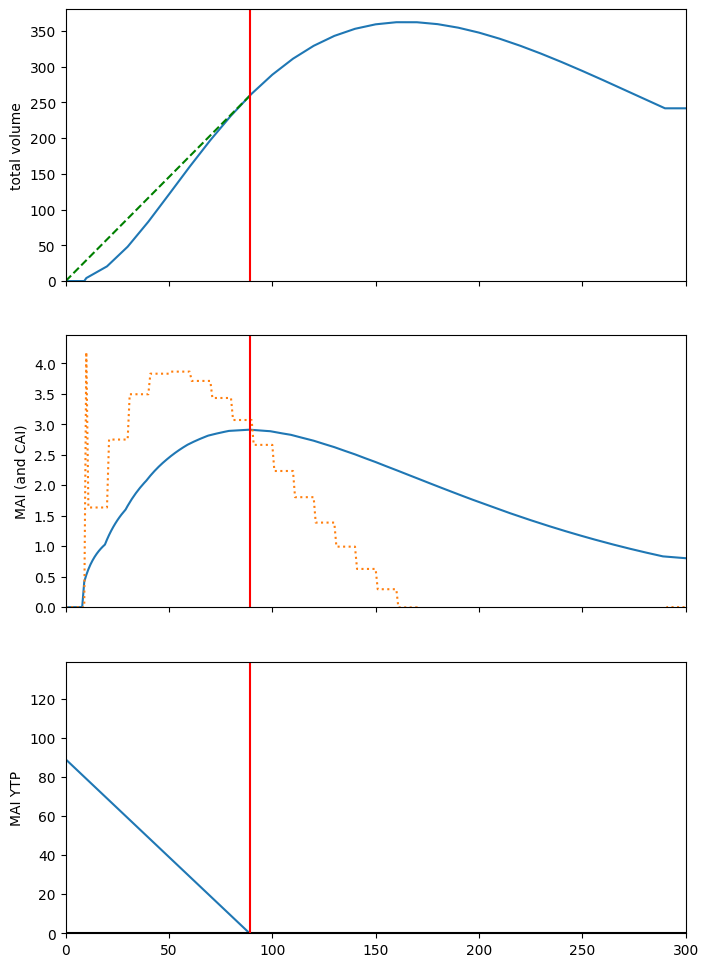

In [88]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

cvol = c
ccai = c.cai()
cmai = c.mai()
cmaiytp = c.mai().ytp()
x_cmai = cmaiytp.lookup(0) # optimal rotation age (i.e., culmination of MAI curve)
labels = 'total volume', 'MAI (and CAI)', 'MAI YTP'

ax[0].plot(*zip(*c.points()))
ax[0].plot([0, x_cmai], [0., cvol[x_cmai]], linestyle='--', color='green')

ax[1].plot(*zip(*c.mai().points()))
ax[1].plot(*zip(*c.cai().points()), linestyle=':')

ax[2].plot(*zip(*c.mai().ytp().points()))
ax[2].axhline(0, color='black')

for i in range(len(ax)):
    ax[i].set_ylabel(labels[i])
    ax[i].set_ylim(0, None)
    ax[i].axvline(x_cmai, color='red')
plt.xlim(0, 300)

## ACTIONS section

The ACTIONS section defines actions that can be applied in the model (e.g., harvesting, planting, thinning, fertilization, etc). 

In [89]:
with open(woodstock_model_files_act_path, 'w') as file:
    print('ACTIONS', file=file)
    print('*ACTION harvest Y', file=file)
    print('*OPERABLE harvest', file=file)
    print('? 1 ? ? ? ? _AGE >= 90 AND _AGE <= 600', file=file)

## TRANSITIONS section

The TRANSITIONS section defines transitions (i.e., transition to a new development type and age class induced by applying a specific action to a specific combination of development type and age class). If there were no transitions in a forest estate model, it would simply be aging (i.e., growing) the forest forward from time step 1 through to time step N.

In [90]:
with open(woodstock_model_files_trn_path, 'w') as file:
    acode = 'harvest'
    print('*CASE', acode, file=file)
    record_au = set()
    for au_id, au_row in stands_table.iterrows():
        if au_row.theme5 in record_au: continue
        if not au_row.theme1: continue
        target_curve_id = au_row.theme4  
        smask = ' '.join(('?', '?', '?', '?', '?', str(target_curve_id)))
        tmask = ' '.join(('?', '?' , '?', '?', str(target_curve_id), '?'))
        print('*SOURCE', smask, file=file)
        print('*TARGET', tmask, '100', file=file)
        record_au.add(au_row.theme5)